# Proyecto Módulo 5 — Aprendizaje Profundo con Redes Neuronales
## Parte 1: Detección de Fake News con Deep Learning (Keras)

**Objetivo:** Entrenar un modelo de Deep Learning capaz de clasificar noticias como *falsas* o *verdaderas*, apoyando el trabajo de fact-checkers.

**Dataset:** Fake News Classification Dataset (Kaggle)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Configuración visual (gráficos)
plt.style.use("seaborn-v0_8")

# Semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
# =========================
# Cargamos el dataset
# =========================
ruta_csv = "../Data/WELFake_Dataset.csv"
df = pd.read_csv(ruta_csv)

print("Tamaño del dataset:", df.shape)
df.head()


Tamaño del dataset: (72134, 4)


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


## Revisión General

In [10]:
# =========================
# Inspeccionamos rápidamente el dataset
# =========================

print("Columnas:", df.columns.tolist()) #vemos los nombres de las columnas
print("\nTipos de datos:\n", df.dtypes) #vemos los tipos de datos de cada columna

print("\nNulos por columna:\n", df.isna().sum()) #vemos la cantidad de valores nulos por columna

duplicados = df.duplicated().sum() #vemos la cantidad de filas duplicadas
print("\nCantidad de filas duplicadas:", duplicados) 


Columnas: ['Unnamed: 0', 'title', 'text', 'label']

Tipos de datos:
 Unnamed: 0     int64
title         object
text          object
label          int64
dtype: object

Nulos por columna:
 Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

Cantidad de filas duplicadas: 0


## Selección de Variables Clave (Texto y etiqueta)

In [5]:
# =========================
# Selección de variables clave (texto y etiqueta)
# =========================
# En este dataset, suele existir 'text' y 'label'. Ajustaremos si fuese necesario.

col_texto = "text"
col_etiqueta = "label"

# Nos quedamos solo con lo necesario para evitar ruido
df_modelo = df[[col_texto, col_etiqueta]].copy()

df_modelo.head()


,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


## Limpieza del Texto

In [ ]:
def limpiar_texto(texto: str) -> str:
    """
    Limpiamos el texto para modelamiento:
    - minúsculas
    - elimina URLs
    - elimina caracteres no alfabéticos (mantiene espacios)
    - normaliza espacios
    """
    texto = str(texto).lower()                        # pasar a minúsculas
    texto = re.sub(r"http\S+|www\.\S+", " ", texto)   # quitar URLs
    texto = re.sub(r"[^a-z\s]", " ", texto)           # dejar solo letras (inglés) y espacios
    texto = re.sub(r"\s+", " ", texto).strip()        # normalizar espacios
    return texto


In [8]:
# =========================
# Limpieza + eliminación de nulos
# =========================

df_modelo = df_modelo.dropna(subset=[col_texto, col_etiqueta]).copy()

df_modelo["texto_limpio"] = df_modelo[col_texto].apply(limpiar_texto)

print("Dimensión después de limpiar nulos:", df_modelo.shape)
df_modelo.head()


Dimensión después de limpiar nulos: (72095, 3)


,text,label,texto_limpio
0,No comment is expected from Barack Obama Membe...,1,no comment is expected from barack obama membe...
1,Did they post their votes for Hillary already?,1,did they post their votes for hillary already
2,"Now, most of the demonstrators gathered last ...",1,now most of the demonstrators gathered last ni...
3,A dozen politically active pastors came here f...,0,a dozen politically active pastors came here f...
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,the rs sarmat missile dubbed satan will replac...


## EDA

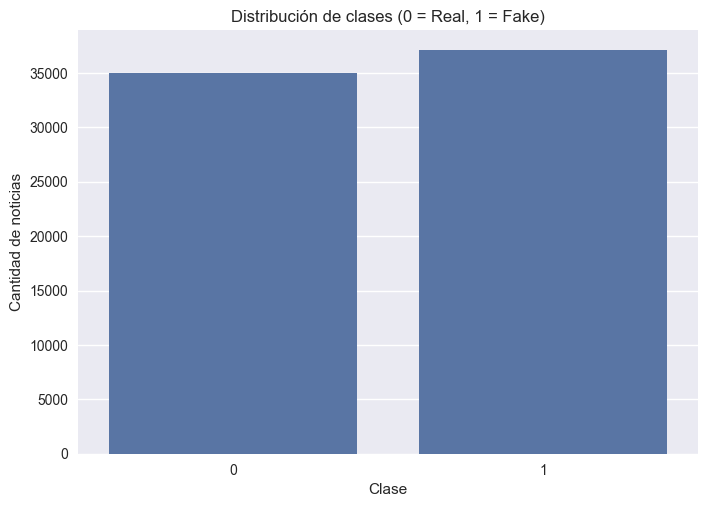

Conteo de clases:
 label
0    35028
1    37067
Name: count, dtype: int64


In [11]:
# =========================
# balanceo de clases
# =========================

conteo_clases = df_modelo[col_etiqueta].value_counts().sort_index()

plt.figure()
sns.barplot(x=conteo_clases.index, y=conteo_clases.values)
plt.title("Distribución de clases (0 = Real, 1 = Fake)")
plt.xlabel("Clase")
plt.ylabel("Cantidad de noticias")
plt.show()

print("Conteo de clases:\n", conteo_clases)


Podemos ver que las clases están balanceadas, es decir, aproximadamente la misma cantidad de falsas y reales, por lo cual el modelo se podrá armar sin sesgos que inclinen los resultados hacia una clasecon más peso.

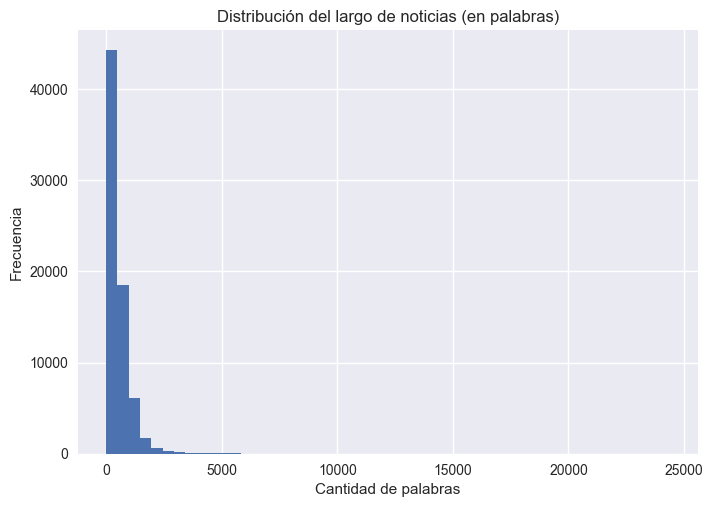

count    72095.000000
mean       543.150884
std        624.839353
min          0.000000
25%        227.000000
50%        402.000000
75%        672.000000
max      24385.000000
Name: largo_texto, dtype: float64


In [ ]:
# ==================================================
# Revisamos la distribución de la longitud del texto
# ==================================================

df_modelo["largo_texto"] = df_modelo["texto_limpio"].apply(lambda x: len(x.split()))

plt.figure()
plt.hist(df_modelo["largo_texto"], bins=50)
plt.title("Distribución del largo de noticias (en palabras)")
plt.xlabel("Cantidad de palabras")
plt.ylabel("Frecuencia")
plt.show()

print(df_modelo["largo_texto"].describe())


El largo de las noticias muestra una distribución normal hacia la izquierda, con curtosis. PudPodemos inferir que hay outliers a la derecha y que más de 40000 noticias tienen por debajo de 1250 palabras.

## División de la data Train/Validación/Test

In [14]:
# =========================
# Separación Train / Validation / Test (70-15-15)
# =========================
X = df_modelo["texto_limpio"].values
y = df_modelo["label"].values

# Paso 1: separar 70% train y 30% temporal
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Paso 2: dividir el 30% temporal en 15% val y 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Distribución final:")
print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))



Distribución final:
Train: 50466
Validation: 10814
Test: 10815


El dataset lo dividimos en **70% entrenamiento**, **15% validación** y **15% prueba**.

- La data de **entrenamiento** se utiliza para ajustar los pesos del modelo.
- La data de **validación** se utiliza para la selección de hiperparámetros y la decisión del número de épocas mediante EarlyStopping.
- La data de **prueba** se reserva para una evaluación final imparcial del desempeño del modelo.

Esta división la hicimos **estratificada**, buscando que la proporción de clases (fake/real) se mantuviera constante en los tres subconjuntos.


## Tokenizer + Padding
Para convertir el texto en secuencias numéricas y dejarlas del mismo largo.

In [59]:

vocabulario_max = 30000   # tamaño máximo del vocabulario
longitud_maxima = 500     # largo máximo de secuencia (palabras)

tokenizador = Tokenizer(num_words=vocabulario_max, oov_token="<OOV>")
tokenizador.fit_on_texts(X_train)

seq_train = tokenizador.texts_to_sequences(X_train)
seq_val = tokenizador.texts_to_sequences(X_val)
seq_test = tokenizador.texts_to_sequences(X_test)

X_train_pad = pad_sequences(seq_train, maxlen=longitud_maxima, padding="post", truncating="post")
X_val_pad   = pad_sequences(seq_val,   maxlen=longitud_maxima, padding="post", truncating="post")
X_test_pad  = pad_sequences(seq_test,  maxlen=longitud_maxima, padding="post", truncating="post")

print("Forma X_train_pad:", X_train_pad.shape)
print("Forma X_val_pad:", X_val_pad.shape)
print("Forma X_test_pad:", X_test_pad.shape)



Forma X_train_pad: (50466, 500)
Forma X_val_pad: (10814, 500)
Forma X_test_pad: (10815, 500)


Las secuencias de texto fueron transformadas a un largo fijo de 400 para que todas las muestras tengan la misma dimensionalidad de entrada, que es necesario para el entrenamiento del modelo secuencial con capa Embedding que haremos a continuación.

## Construcción y entrenamiento del Modelo de Deep Learning

In [60]:
# =================================
# Construimos el modelo con Keras 
# =================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

MAX_NB_WORDS = vocabulario_max        
MAX_SEQUENCE_LENGTH = longitud_maxima 

# Creamos el modelo secuencial
model = Sequential()

# Capa de embedding
model.add(Embedding(
    input_dim=MAX_NB_WORDS,
    output_dim=128
))

# Capa Flatten
model.add(Flatten())

# Capa densa oculta
model.add(Dense(64, activation="relu"))

# Regularización con Dropout
model.add(Dropout(0.5))

# Capa de salida con activación sigmoide (clasificación binaria)
model.add(Dense(1, activation="sigmoid"))

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# construimos el modelo explícitamente
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Resumen del modelo
model.summary()



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 500, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 64000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │     4,096,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,936,129 (30.27 MB)

 Trainable params: 7,936,129 (30.27 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# =========================
# Entrenamos el modelo (con el split 70-15-15 que definimos antes)
# - Para entrenar: X_train_pad, y_train
# - Para validar: X_val_pad, y_val
# =========================
historial = model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=512,
    verbose=1
)




Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 225ms/step - accuracy: 0.7215 - loss: 0.5589 - val_accuracy: 0.8734 - val_loss: 0.3362
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 0.9021 - loss: 0.2579 - val_accuracy: 0.9122 - val_loss: 0.2156
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - accuracy: 0.9379 - loss: 0.1716 - val_accuracy: 0.9331 - val_loss: 0.1690
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.9592 - loss: 0.1248 - val_accuracy: 0.9410 - val_loss: 0.1485
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.9726 - loss: 0.0931 - val_accuracy: 0.9471 - val_loss: 0.1329
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.9819 - loss: 0.0708 - val_accuracy: 0.9516 - val_loss: 0.1225
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.9878 - loss: 0.0529 - val_accuracy: 0.9540 - val_loss: 0.1160
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.9930 - loss: 0.0396 - val_accu

Al ver el entrenamiento del modelo, **selecciono la época 4 como la óptima para evitar sobreajuste**, mis conclusiones para esta decisión son:

1.- La diferencia entre la pérdida de validación y la de entrenamiento no es grande en la época 4, por lo que podemos decir que no hay sobreajuste.

2.- Aunque la precisión de validación aumenta en las épocas posteriores a la época 4, la función de pérdida de ésta muestra mejor la capacidad de generalización del modelo, ya que la diferencia entre la pérdida de validación y la de entrenamiento es menor que las épocas posteriores.

3.- La época 4 tiene 94% de accuracy en validación para fake news, lo cual es muy buen desempeño. 

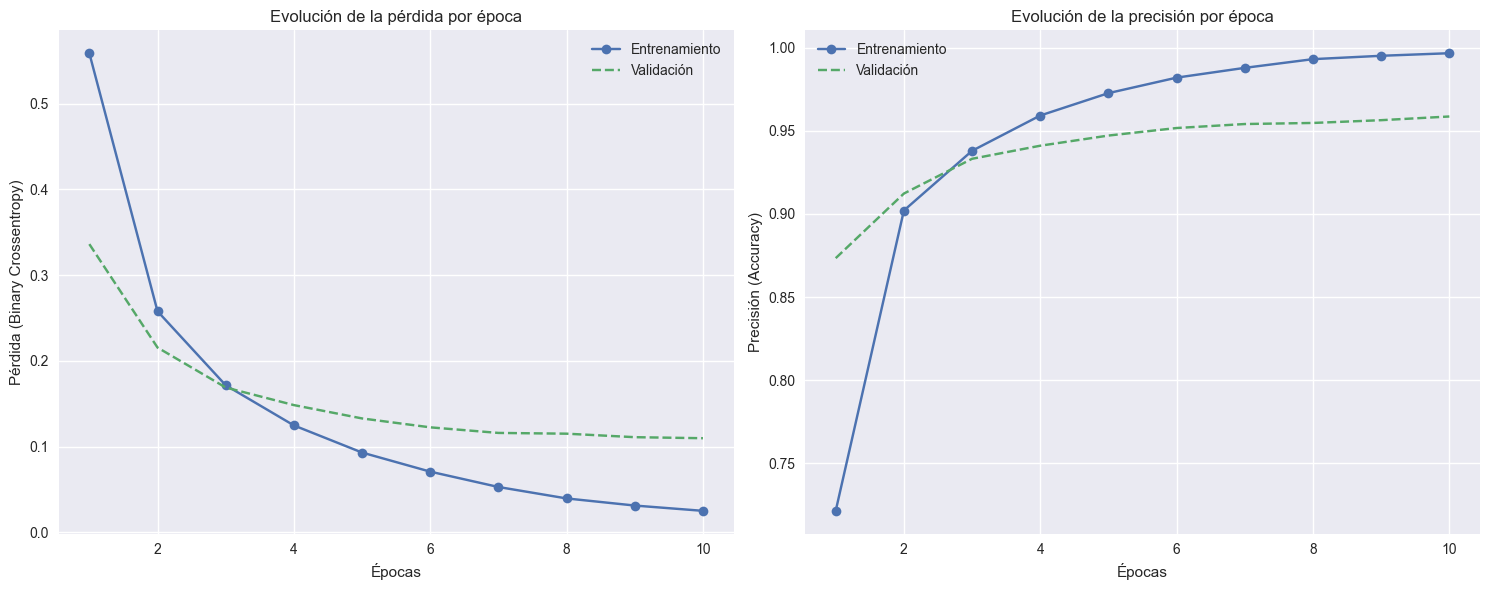

In [64]:
# ======================================================
# Gráficos de pérdida y precisión (Train vs Validation)
# ======================================================

plt.figure(figsize=(15, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, len(historial.history["loss"]) + 1), historial.history["loss"], "o-", label="Entrenamiento")
plt.plot(range(1, len(historial.history["val_loss"]) + 1), historial.history["val_loss"], "--", label="Validación")
plt.title("Evolución de la pérdida por época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Binary Crossentropy)")
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, len(historial.history["accuracy"]) + 1), historial.history["accuracy"], "o-", label="Entrenamiento")
plt.plot(range(1, len(historial.history["val_accuracy"]) + 1), historial.history["val_accuracy"], "--", label="Validación")
plt.title("Evolución de la precisión por época")
plt.xlabel("Épocas")
plt.ylabel("Precisión (Accuracy)")
plt.legend()

plt.tight_layout()
plt.show()


También en las gráficas se observa que la pérdida de validación alcanza su mejor valor alrededor de la época 4. Luego, la mejora se estanca o empeora, lo que sugiere inicio de sobreajuste. Por este motivo **se selecciona la época 4 como punto óptimo.**

## Evaluación del Modelo

In [65]:
# =========================
# Evaluación final en Test
# =========================

loss_test, acc_test = model.evaluate(X_test_pad, y_test, verbose=0)

print(f"Pérdida en Test: {loss_test:.4f}")
print(f"Precisión en Test: {acc_test:.4f}")


Pérdida en Test: 0.1135
Precisión en Test: 0.9581


In [66]:
# =========================
# Predicciones en Test
# =========================
y_prob = model.predict(X_test_pad, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("Reporte de clasificación (Test):")
print(classification_report(y_test, y_pred, target_names=["REAL (0)", "FAKE (1)"]))


Reporte de clasificación (Test):
              precision    recall  f1-score   support

    REAL (0)       0.97      0.94      0.96      5255
    FAKE (1)       0.94      0.98      0.96      5560

    accuracy                           0.96     10815
   macro avg       0.96      0.96      0.96     10815
weighted avg       0.96      0.96      0.96     10815



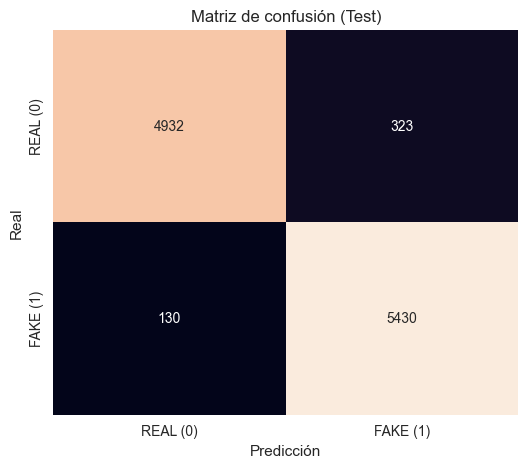

In [69]:
# =================================
# Matriz de confusión (con gráfico)
# =================================

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Matriz de confusión (Test)")
plt.xlabel("Predicción")
plt.ylabel("Real")

plt.xticks([0.5, 1.5], ["REAL (0)", "FAKE (1)"])
plt.yticks([0.5, 1.5], ["REAL (0)", "FAKE (1)"])

plt.show()


## Evaluación del modelo

El modelo tuvo una **precisión global aproximada de 96%** en el conjunto de prueba, indicando una buena capacidad de generalización.

El análisis por clase muestra que el modelo presenta un **alto recall para la clase FAKE (de 0.98)**, lo que es especialmente relevante en el contexto de detección de noticias falsas, ya que minimiza la cantidad de fake news que pasan desapercibidas.

La matriz de confusión evidencia un número reducido de errores en ambas clases, confirmando un desempeño balanceado y alineado con los resultados observados durante la validación.


## Predicción de noticia Nueva

In [71]:
# =======================================
# Función para predecir una noticia nevaa
# =======================================

def predecir_noticia(texto_noticia: str) -> dict:

    # Limpieza del texto de la noticia
    texto_limpio = limpiar_texto(texto_noticia)

    # Tokenización
    secuencia = tokenizador.texts_to_sequences([texto_limpio])

    # Padding
    X_pad = pad_sequences(
        secuencia,
        maxlen=MAX_SEQUENCE_LENGTH,
        padding="post",
        truncating="post"
    )

    # Predicción
    prob_fake = float(model.predict(X_pad, verbose=0)[0][0])
    prediccion = "FAKE" if prob_fake >= 0.8 else "REAL"

    return {
        "prob_fake": prob_fake,
        "prediccion": prediccion
    }


**Prueba del modelo con una Noticia FALSA**

In [72]:
texto_noticia_falsa = """Exposed: FBI Director James Comey’s Clinton Foundation Connection WASHINGTON, D.C. — A review of FBI Director James Comey’s professional history and relationships shows that the Obama cabinet leader — now under fire for his handling of the investigation of Hillary Clinton — is deeply entrenched in the big-money cronyism culture of Washington, D.C. His personal and professional relationships — all undisclosed as he announced the Bureau would not prosecute Clinton — reinforce bipartisan concerns that he may have politicized the criminal probe.

These concerns focus on millions of dollars that Comey accepted from a Clinton Foundation defense contractor, Comey’s former membership on a Clinton Foundation corporate partner’s board, and his surprising financial relationship with his brother Peter Comey, who works at the law firm that does the Clinton Foundation’s taxes.

Lockheed Martin

When President Obama nominated Comey to become FBI director in 2013, Comey promised the United States Senate that he would recuse himself on all cases involving former employers.

But Comey earned $6 million in one year alone from Lockheed Martin. Lockheed Martin became a Clinton Foundation donor that very year.

Comey served as deputy attorney general under John Ashcroft for two years of the Bush administration. When he left the Bush administration, he went directly to Lockheed Martin and became vice president, acting as a general counsel.

How much money did James Comey make from Lockheed Martin in his last year with the company, which he left in 2010? More than $6 million in compensation.

Lockheed Martin is a Clinton Foundation donor. The company admitted to becoming a Clinton Global Initiative member in 2010.

According to records, Lockheed Martin is also a member of the American Chamber of Commerce in Egypt, which paid Bill Clinton $250,000 to deliver a speech in 2010.

In 2010, Lockheed Martin won 17 approvals for private contracts from the Hillary Clinton State Department.

HSBC Holdings

In 2013, Comey became a board member, a director, and a Financial System Vulnerabilities Committee member of the London bank HSBC Holdings.

“Mr. Comey’s appointment will be for an initial three-year term which, subject to re-election by shareholders, will expire at the conclusion of the 2016 Annual General Meeting,” according to HSBC company records.

HSBC Holdings and its various philanthropic branches routinely partner with the Clinton Foundation. For instance, HSBC Holdings has partnered with Deutsche Bank through the Clinton Foundation to “retrofit 1,500 to 2,500 housing units, primarily in the low- to moderate-income sector” in “New York City.”

“Retrofitting” refers to a Green initiative to conserve energy in commercial housing units. Clinton Foundation records show that the Foundation projected “$1 billion in financing” for this Green initiative to conserve people’s energy in low-income housing units.

Who Is Peter Comey?

When our source called the Chinatown offices of D.C. law firm DLA Piper and asked for “Peter Comey,” a receptionist immediately put him through to Comey’s direct line. But Peter Comey is not featured on the DLA Piper website.

Peter Comey serves as “Senior Director of Real Estate Operations for the Americas” for DLA Piper. James Comey was not questioned about his relationship with Peter Comey in his confirmation hearing.

DLA Piper is the firm that performed the independent audit of the Clinton Foundation in November during Clinton-World’s first big push to put the email scandal behind them. DLA Piper’s employees taken as a whole represent a major Hillary Clinton 2016 campaign donation bloc and Clinton Foundation donation base.

DLA Piper ranks #5 on Hillary Clinton’s all-time career Top Contributors list, just ahead of Goldman Sachs.

And here is another thing: Peter Comey has a mortgage on his house that is owned by his brother James Comey, the FBI director.

Peter Comey’s financial records, obtained by Breitbart News, show that he bought a $950,000 house in Vienna, Virginia, in June 2008. He needed a $712,500 mortgage from First Savings Mortgage Corporation.

But on January 31, 2011, James Comey and his wife stepped in to become Private Party lenders. They granted a mortgage on the house for $711,000. Financial records suggest that Peter Comey took out two such mortgages from his brother that day.

This financial relationship between the Comey brothers began prior to James Comey’s nomination to become director of the FBI.

DLA Piper did not answer Breitbart News’ question as to whether James Comey and Peter Comey spoke at any point about this mortgage or anything else during the Clinton email investigation.

Peter Comey Re-Designed the FBI Building

FBI Director James Comey grew up in the New Jersey suburbs with his brother Peter. Both Comeys were briefly taken captive in 1977 by the “Ramsey rapist,” but the boys managed to escape through a window in their home, and neither boy was harmed.

James Comey became a prosecutor who worked on the Gambino crime family case. He went on to the Bush administration, a handful of private sector jobs, and then the Obama administration in 2013.

Peter Comey, meanwhile, went into construction.

After getting an MBA in real estate and urban development from George Washington University in 1998, Peter Comey became an executive at a company that re-designed George Washington University between 2004 and 2007 while his brother was in town working for the Bush administration.

In January 2009, at the beginning of the Obama administration, Peter Comey became “a real estate and construction consultant” for Procon Consulting.

Procon Consulting’s client list includes “FBI Headquarters Washington, DC.”

So what did Procon Consulting do for FBI Headquarters? Quite a bit, apparently. According to the firm’s records:

Procon provided strategic project management for the consolidation of over 11,000 FBI personnel into one, high security, facility.

Since 1972 the Federal Bureau of Investigation has had its headquarters in a purpose built 2.1 million square foot building on Pennsylvania Avenue. Having become functionally obsolete and in need of major repairs, GSA and the FBI were considering ways to meet the space needs required to maintain the Bureau’s mission and consolidate over 11,000 personnel.

Procon assisted GSA in assessing the FBI’s space needs and options for fulfilling those needs. Services provided included project management related to site evaluations, budgeting, due diligence, and the development of procurement and funding strategies.

Those “funding strategies” included talking to “stakeholders”: “Worked with stakeholders and key leadership to identify strategic objectives, goals and long range plans for capital and real estate projects.”

Procon Consulting obtained its contract for FBI Headquarters prior to James Comey’s nomination to serve as director of the FBI.

In June 2011, Peter Comey left Procon Consulting to become “Senior Director of Real Estate Operations for the Americas” for DLA Piper.

Peter Comey has generated some controversy in that role. According to Law360 in May 2013 (the same month that James Comey was confirmed as someone being considered by Obama to become FBI director):

Two real estate services businesses filed a $10 million suit against the law firm Monday alleging it stiffed them on as much as $760,000 of work done at DLA Piper’s Chicago office and improperly gave proprietary information to a competitor.

….

The plaintiffs take particular aim at Peter Comey, DLA Piper’s senior director of real estate operations. Leasecorp and SpaceLogik include several emails in the complaint that are purportedly from DLA Piper senior real estate partners Jay Epstein and Rich Klawiter and are sharply critical of Comey’s handling of the matter. In one email, Epstein wrote that “it’s an embarrassment for the firm to be treating someone who we are working with like this.”

In another email allegedly from Klawiter on Feb. 20, the DLA Piper partner informed Leasecorp President Michael Walker, a principal for both plaintiffs, that Comey had sent him and Epstein an email claiming that the real estate services firms were behind on their contractual obligations.

“I just received an email from Peter (Jay was also a recipient) that is so inflammatory I can’t even send it or you’ll hit the roof,” Klawiter said in the email, according to the complaint. “This is not going to end well.”
"""

resultado_falsa = predecir_noticia(texto_noticia_falsa)
print("Resultado noticia falsa:\n", resultado_falsa)


Resultado noticia falsa:
 {'prob_fake': 0.9507426023483276, 'prediccion': 'FAKE'}


Conclusión de la Prueba con noticia falsa: 
El modelo arrojó una probabilidad de **95%** para la clase **FAKE**, clasificando correctamente la noticia como **falsa**, lo que confirma la capacidad del modelo para evaluar textos externos.


**Prueba del modelo con una noticia VERDADERA**

In [74]:
texto_noticia_verdadera = """World Cup
In Qatar, one of the World Cup’s first female refs will live an ‘impossible dream’
November 14, 2022
More than 
3 years ago By Thomas Floyd
Kathryn Nesbitt had spent a decade balancing parallel careers in analytical chemistry and soccer officiating when, in 2019, she put her scientific brain to work and synthesized a solution for the most pragmatic path forward.

Two weeks before Nesbitt left for France to serve as an assistant referee at the Women’s World Cup, she stepped down from her assistant professor position at Towson University to focus on officiating full time. What data points informed that decision? She reached the pinnacle of women’s soccer refereeing that summer and had broken into top-flight men’s soccer as well, with dozens of MLS games under her belt. Knowing the 2026 men’s World Cup would be held in the United States, Canada and Mexico, Nesbitt mapped out a plan that would culminate in her being on the sideline of the sport’s premier spectacle.

“I had no idea if they’d ever let women officiate at that World Cup, but I wanted to see if I could do that,” said Nesbitt, 34. “I realized at the time that in order to even attempt that, I would need to dedicate all of my time and effort into one job.” Once Nesbitt shifted her focus to officiating, her ascent accelerated. In 2020, she claimed MLS assistant referee of the year honors and became the first woman to officiate an MLS Cup final. A few months later, Concacaf — the confederation that oversees soccer in North America, Central America and the Caribbean — tasked her with men’s World Cup qualifying assignments. By the time FIFA, soccer’s global governing body, announced its pool of referees for the 2022 World Cup in Qatar, the Philadelphia-based official thought she might have a shot. On May 19, Nesbitt woke up, scrolled through Twitter and saw FIFA’s unveiling. The tournament, FIFA stated in its announcement, would feature the first female referees in the 92-year history of the men’s World Cup, with six women among the 129 officials. Zooming in on the 69 assistant referees, she saw the listing: “NESBITT Kathryn. USA.”

“I just got jaw-dropped, stared at it, couldn’t even believe that this was happening,” Nesbitt recalled. “Then I probably jumped around the room for the next 20 minutes.” Nesbitt prides herself, as a referee or a chemist, in processing the information at her disposal and arriving at the right conclusion. But in calculating her path to a men’s World Cup assignment, she shortchanged herself — by four years, in fact.

“She certainly achieves the highest standard in everything that she does,” said Mark Geiger, a former MLS, Olympic and World Cup referee who now serves as the director of senior match officials at the U.S.-based Professional Referee Organization. “She doesn’t settle for anything. She sets goals for herself, and she does everything that she possibly can to achieve those goals, whether it’s in the science field or whether it’s on the soccer field.” A soccer player in her youth, Nesbitt was a restless 14-year-old sitting through her little brother’s games in Rochester, N.Y., when she first volunteered to be an assistant referee (commonly known as a linesman). The role typically involves making throw-in, goal kick, corner kick, foul and offside calls, but as a teen volunteer with a familial conflict of interest, Nesbitt was simply asked to wave the flag when the ball went out of bounds and leave the rest to the paid referee.

“Then one of the guys actually asked me, ‘Hey, would you like to make money doing this?’ ” Nesbitt said. “And I was like, ‘Yeah, that sounds great.’ ” A senior-level figure skater and a volleyball player who competed for St. John Fisher University in Rochester, Nesbitt divided her time among no shortage of athletic exploits. Around the time she was wrapping up her college career, she began serving as a fourth official — a largely administrative role stationed between the team benches — for games involving Rochester’s minor league men’s team. Before long, Nesbitt landed a spot in a now-defunct U.S. Soccer program for fast-tracking top officiating prospects. In 2013, she became an assistant referee for the NWSL. Felisha Mariscal broke through as an MLS official a year later, and Nesbitt made her MLS debut in 2015. But even as she rose up the ranks, soccer remained a side hustle. After studying chemistry as a graduate student at the University of Pittsburgh and completing a postdoctoral research fellowship at Michigan, Nesbitt joined the faculty at Towson, a public university in Maryland, in 2017. For the better part of two years, she did some 50 hours of lab research per week. Most Friday nights, Nesbitt would crawl to the airport through Baltimore rush-hour traffic and hop on a plane — to Los Angeles, Minnesota or wherever else her MLS assignments took her. After officiating a match, she would fly back Sunday night and do it all again. “She managed those competing responsibilities exceptionally well,” said John Sivey, a professor who worked with Nesbitt in Towson’s chemistry department. “I don’t know how she did it, to be very honest, because the demands of both of those careers can be pretty substantial.”

After those long days of lab research, Nesbitt would flip on MLS games or devour film of the teams she would be officiating that weekend. Deeply understanding each club’s players and tactics allows her to better anticipate the flow of the game, she reasoned, and helps her parlay her strengths in academia to the soccer pitch. “One of the characteristics that I think strongly overlaps between a very good sports official and a very good analytical chemist is precision,” said Sivey, himself a former high school baseball and softball umpire and basketball referee. “For precision in analytical chemistry, we basically mean: How repeatable or reproducible is a particular experiment? In the sports officiating world, I think that looks a lot like consistency.” To Geiger, who officiated alongside Nesbitt before retiring as a referee in 2019, that precision is just one of Nesbitt’s strengths. As a 6-foot former college athlete, she has no problem acing refereeing fitness standards designed for men. And Geiger can’t recall seeing her rattled, even in games that threatened to spiral out of the referee crew’s control.

“She not only can analyze what the correct decision should be, but she also knows from a feeling aspect what the best decision for the game would be,” Geiger said. “And they’re not always the same. Sometimes you need to really feel the game and know what the best decision is at that particular moment and what’s going to help the referee group maintain control of the game. She understands that.”

 Although MLS recently completed its eighth season using female referees, Nesbitt last year became the first woman to officiate Concacaf men’s World Cup qualifying games. She remembered getting plenty of stares from players, especially in those first few matches. Nesbitt said match coordinators also tended to mistakenly assume she was just the fourth official, there to help with substitutions and timekeeping but not roam the pitch.“One of the biggest things I’ve learned in my career — and this has been in chemistry too, both being very male-heavy areas — is the best way to impress is to do your job well,” Nesbitt said. “But it would always be funny the first time I would do a sprint with one of the players down to the corner flag, and he’d look over, and I’d be keeping up with him. I think that had a really big effect just gaining some respect.”

Within months of her first men’s qualifier, Nesbitt had gained enough respect to book her ticket to Qatar. On that May morning when FIFA unveiled the World Cup officials, Sivey went door to door through the Towson chemistry department to excitedly share the news of their former colleague’s new assignment. Eventually, Nesbitt figures she will hang up her cleats, stash away her flag and return to chemistry. For now, though, she understands her status as a soccer trailblazer — even if hearing that label prompts her to let out an embarrassed groan. As she prepares to make World Cup history, Nesbitt revels, appropriately enough, in the satisfaction that she made the right call back in 2019.

“This was an impossible dream for me, and just being able to witness females at this event now makes this realistic for all women,” Nesbitt said. “Whether it be in refereeing, whether it be in a different sport, whether it be in something completely different — sometimes just having a visual like that can make something actually be real. If I get to play even a small role in that, that’s really cool.”
"""

resultado_verdadera = predecir_noticia(texto_noticia_verdadera)
print("Resultado noticia verdadera:", resultado_verdadera)


Resultado noticia verdadera: {'prob_fake': 0.7863950729370117, 'prediccion': 'REAL'}


Conclusión de la prueba con noticia verdadera: Inicialmente, la noticia fue clasificada erróneamente por el modelo, calificándola de "Fake" con un 85% de probabilidad, Yo supuse que este error fue debido a la presencia de elementos no textuales (imágenes y captions) incluidos en el texto de entrada, principalmente porque copié y pegué todo lo que aparecía en la web de la noticia.

Después hice un copy-paste del texto, esta vez cuidando no copiar y pegar imágenes o elementos gráficos de la noticia. Haciendo eso, el modelo clasificó correctamente la noticia como **REAL**, con una probabilidad asociada a *fake* de **0.78**.

Este experimento evidencia la importancia del preprocesamiento del texto y las limitaciones que pueden haber cuando la data se importa de manera incorrecta o con información que no es texto, o cuando los modelos se limitan exclusivamente a texto.
